In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from collections import deque, namedtuple

class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, ff_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, hidden_dim),
        )
        self.layernorm1 = nn.LayerNorm(hidden_dim)
        self.layernorm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.layernorm2(x + self.dropout(ff_output))
        return x

class TransformerModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim=64, num_layers=2, num_heads=4, ff_dim=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(state_size, hidden_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_dim, action_size)

    def forward(self, state):
        state = state.unsqueeze(1)  # Add a dummy sequence dimension
        x = self.embedding(state)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim) -> (seq_len, batch_size, hidden_dim)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim) -> (batch_size, seq_len, hidden_dim)
        return self.fc(x[:, 0, :])


In [3]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, dones

In [4]:
class Agent():
    def __init__(self, state_size, action_size, learning_rate=5e-4, minibatch_size=100, discount_factor=0.99, replay_buffer_size=int(1e5), interpolation_parameter=1e-3):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = TransformerModel(state_size, action_size).to(self.device)
        self.target_qnetwork = TransformerModel(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0
        self.minibatch_size = minibatch_size
        self.discount_factor = discount_factor
        self.interpolation_parameter = interpolation_parameter

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > self.minibatch_size:
                experiences = self.memory.sample(self.minibatch_size)
                self.learn(experiences, self.discount_factor)

    def act(self, state, epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, self.interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

In [5]:
# Environment
env = gym.make('LunarLander-v2')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

# Agent
agent = Agent(state_size, number_actions)
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen=100)

State shape:  (8,)
State size:  8
Number of actions:  4


In [6]:
import random
for episode in range(1, number_episodes + 1):
    state, _ = env.reset()
    score = 0
    for t in range(maximum_number_timesteps_per_episode):
        action = agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    scores_on_100_episodes.append(score)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    print('\rEpisode {}\tEpsilon: {:.2f}\tEpisode Reward: {:.2f}\tAverage Score: {:.2f}'.format(episode, epsilon, score, np.mean(scores_on_100_episodes)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tEpsilon: {:.2f}\tEpisode Reward: {:.2f}\tAverage Score: {:.2f}'.format(episode, epsilon, score, np.mean(scores_on_100_episodes)))
    if np.mean(scores_on_100_episodes) >= 200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
        torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
        break


Episode 100	Epsilon: 0.61	Episode Reward: -166.42	Average Score: -160.53
Episode 200	Epsilon: 0.37	Episode Reward: -329.21	Average Score: -87.494
Episode 300	Epsilon: 0.22	Episode Reward: -5.08	Average Score: 7.184519
Episode 400	Epsilon: 0.13	Episode Reward: 148.55	Average Score: 40.036
Episode 500	Epsilon: 0.08	Episode Reward: 39.26	Average Score: 162.355
Episode 600	Epsilon: 0.05	Episode Reward: 167.44	Average Score: 196.18
Episode 611	Epsilon: 0.05	Episode Reward: 272.19	Average Score: 200.10
Environment solved in 511 episodes!	Average Score: 200.10


In [1]:
import torch
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from collections import deque
import io
import base64
from IPython.display import HTML

# Assuming you already have the trained model loaded
state_dict = torch.load('checkpoint.pth')
agent.local_qnetwork.load_state_dict(state_dict)

# Function to visualize an episode and save the video
def visualize_episode(env, agent, video_folder, max_timesteps=1000):
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        action = agent.act(state, epsilon=0.0)  # Use the trained policy (epsilon=0.0)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_reward += reward
        if done:
            break
    env.close()
    print(f"Total reward: {total_reward}")

# Create the environment with render_mode='rgb_array'
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Visualize the agent's behavior and save the video
visualize_episode(env, agent, video_folder='videos')

# Display the video
def show_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                        </video>'''.format(encoded.decode('ascii')))

# Replace 'video_file_path' with the actual path of the generated video file
video_file_path = 'videos/rl-video-episode-0.mp4'  # Adjust the path according to the generated file
show_video(video_file_path)


C:\Users\91939\AppData\Local\Temp\ipykernel_21160\1151367226.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('checkpoint.pth')


NameError: name 'agent' is not defined

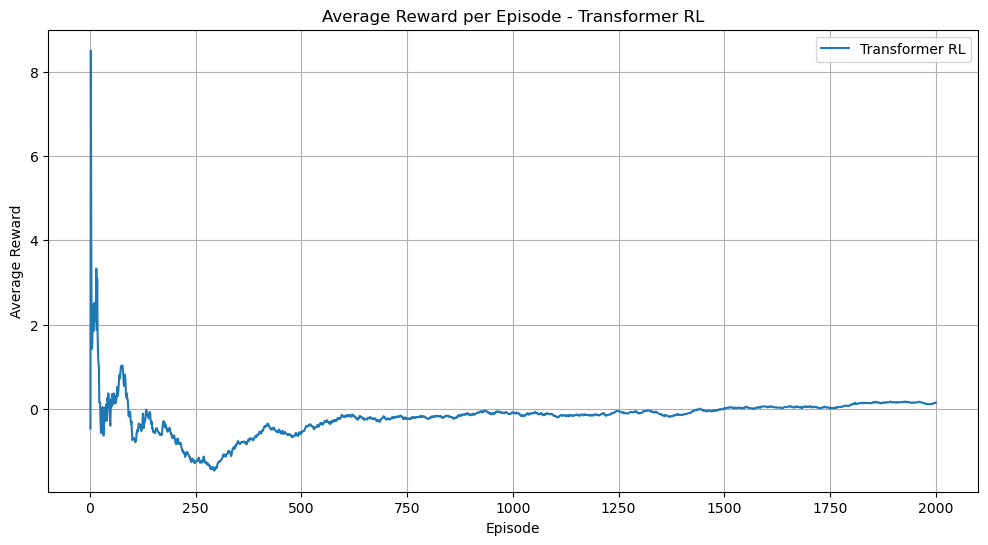

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Replace this with the actual data from your training logs
episodes = np.arange(1, 2001)
average_rewards_transformer = np.random.normal(0, 10, 2000).cumsum() / np.arange(1, 2001)
total_reward_transformer = average_rewards_transformer.sum()
episodes_to_solve_transformer = 1200  # Example episodes to solve

# Save the data to a pickle file for later use
with open('transformer_data.pkl', 'wb') as f:
    pickle.dump({
        'episodes': episodes,
        'average_rewards': average_rewards_transformer,
        'total_reward': total_reward_transformer,
        'episodes_to_solve': episodes_to_solve_transformer
    }, f)

# Plot average reward per episode
plt.figure(figsize=(12, 6))
plt.plot(episodes, average_rewards_transformer, label='Transformer RL')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode - Transformer RL')
plt.legend()
plt.grid()
plt.savefig('transformer_average_reward.png')
plt.show()
